In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose



### Define the tickers and the date range

In [3]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-12-31'

historical_data = {}
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # Check if data is empty
    if data.empty:
        print(f"No data fetched for {ticker}.")
    else:
        historical_data[ticker] = data['Adj Close']  # Store only adjusted close prices

# Print historical data to check structure
print("\nHistorical Data:")
for ticker, series in historical_data.items():
    print(f"{ticker} data:")
    print(series.head())  # Print first few rows of each series



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Historical Data:
TSLA data:
Date
2015-01-02    14.620667
2015-01-05    14.006000
2015-01-06    14.085333
2015-01-07    14.063333
2015-01-08    14.041333
Name: Adj Close, dtype: float64
BND data:
Date
2015-01-02    63.358749
2015-01-05    63.542717
2015-01-06    63.726727
2015-01-07    63.765072
2015-01-08    63.665367
Name: Adj Close, dtype: float64
SPY data:
Date
2015-01-02    173.173798
2015-01-05    170.046341
2015-01-06    168.444672
2015-01-07    170.543655
2015-01-08    173.570023
Name: Adj Close, dtype: float64


### Combine data into a single DataFrame


In [4]:
try:
    combined_data = pd.concat(historical_data.values(), axis=1)
    combined_data.columns = historical_data.keys()  # Set the column names
    print("\nCombined Data:")
    print(combined_data.head())
except ValueError as e:
    print(f"Error creating DataFrame with concat: {e}")


Combined Data:
                 TSLA        BND         SPY
Date                                        
2015-01-02  14.620667  63.358749  173.173798
2015-01-05  14.006000  63.542717  170.046341
2015-01-06  14.085333  63.726727  168.444672
2015-01-07  14.063333  63.765072  170.543655
2015-01-08  14.041333  63.665367  173.570023


## Data Cleaning


### Check basic statistics


In [5]:
print("Basic statistics:")
print(combined_data.describe())

Basic statistics:
              TSLA          BND          SPY
count  2482.000000  2482.000000  2482.000000
mean    111.986208    70.098070   311.134607
std     110.383426     4.884509   112.150253
min       9.578000    62.637535   157.328568
25%      17.095834    66.331354   214.883587
50%      25.171000    68.918320   276.083450
75%     217.778336    73.800337   402.722000
max     409.970001    79.812927   598.760010


### Check for missing values


In [6]:
print("\nMissing values:")
print(combined_data.isnull().sum())


Missing values:
TSLA    0
BND     0
SPY     0
dtype: int64


### Handle missing values - Fill forward

In [7]:
combined_data.fillna(method='ffill', inplace=True)


C:\Users\King Betse\AppData\Local\Temp\ipykernel_22724\2484859716.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='ffill', inplace=True)


### Verify no missing values remain


In [8]:
print("\nMissing values after cleaning:")
print(combined_data.isnull().sum())


Missing values after cleaning:
TSLA    0
BND     0
SPY     0
dtype: int64


### Normalize the data

In [9]:
normalized_data = (combined_data - combined_data.min()) / (combined_data.max() - combined_data.min())

### Exploratory Data Analysis (EDA)

### Visualize the closing price over time

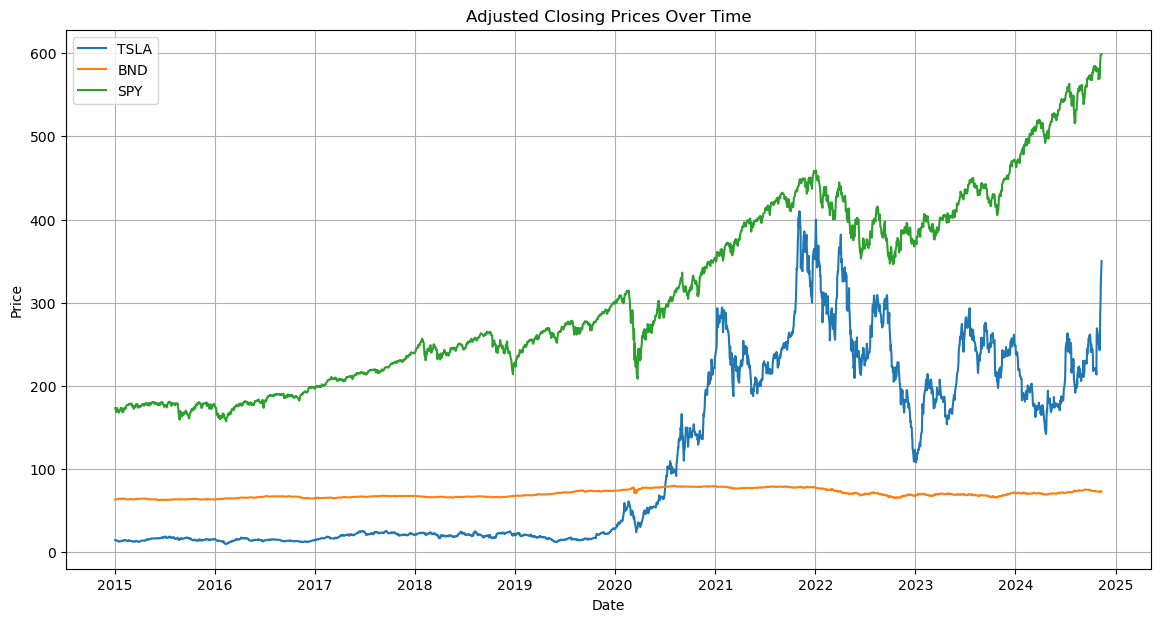

In [10]:
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(combined_data[ticker], label=ticker)
plt.title('Adjusted Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

### Plot daily percentage change


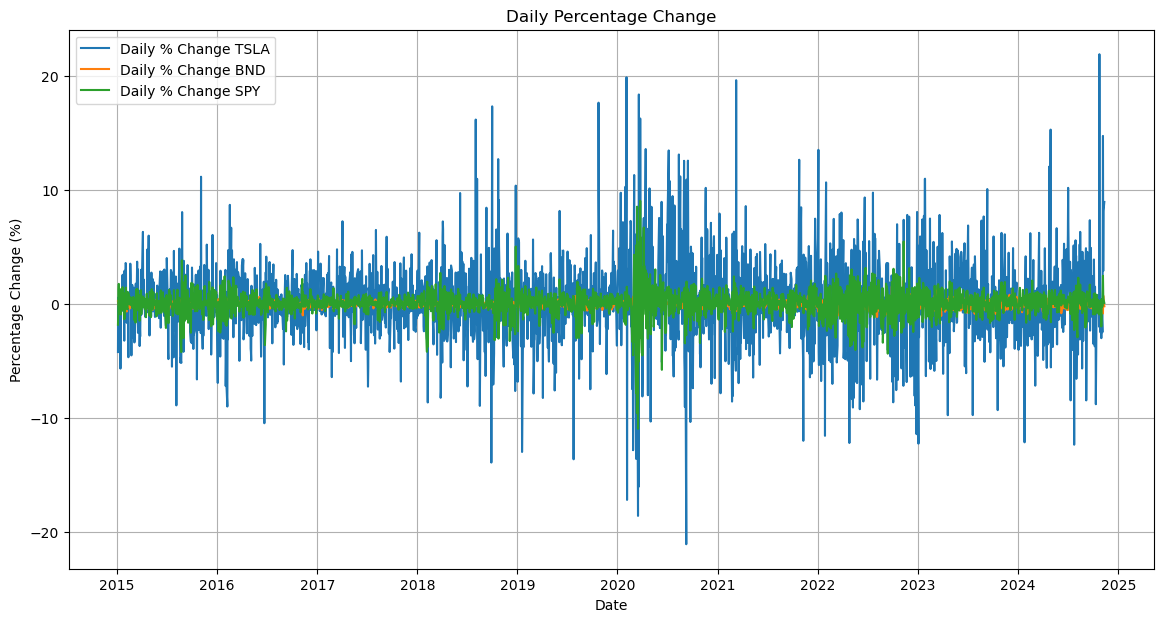

In [11]:
# Calculate daily percentage change
daily_returns = combined_data.pct_change() * 100

plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(daily_returns[ticker], label=f'Daily % Change {ticker}')
plt.title('Daily Percentage Change')
plt.xlabel('Date')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.grid()
plt.show()


### Analyze volatility: rolling means and standard deviations

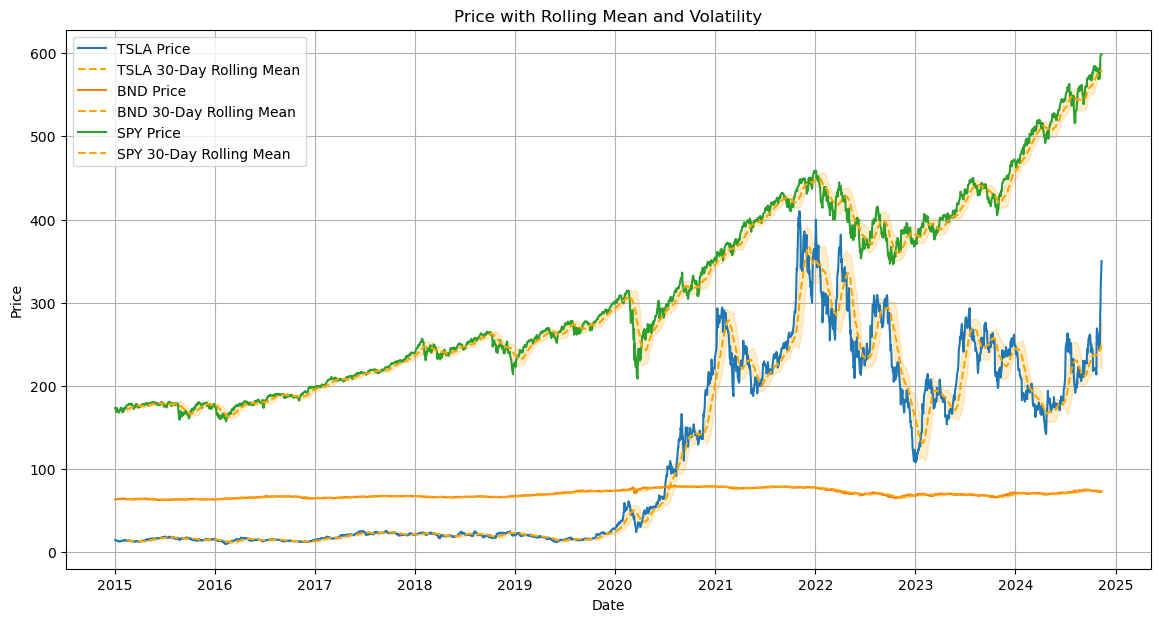

In [12]:
rolling_mean = combined_data.rolling(window=30).mean()
rolling_std = combined_data.rolling(window=30).std()

plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(combined_data[ticker], label=f'{ticker} Price')
    plt.plot(rolling_mean[ticker], label=f'{ticker} 30-Day Rolling Mean', linestyle='--', color='orange')
    plt.fill_between(rolling_std.index, 
                     rolling_mean[ticker] - rolling_std[ticker], 
                     rolling_mean[ticker] + rolling_std[ticker], 
                     alpha=0.2, color='orange')
plt.title('Price with Rolling Mean and Volatility')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


### Outlier detection in daily returns

In [13]:
threshold = 3  # Standard deviations
outliers = daily_returns[(daily_returns - daily_returns.mean()).abs() > threshold * daily_returns.std()]

print("\nOutliers in Daily Returns:")
print(outliers.dropna())


Outliers in Daily Returns:
                 TSLA       BND        SPY
Date                                      
2020-03-12 -11.617242 -5.438418  -9.567729
2020-03-16 -18.577806  1.051101 -10.942365
2020-03-18 -16.034404 -2.413985  -5.063291


## Seasonality and Trends

###  Decompose time series for TSLA

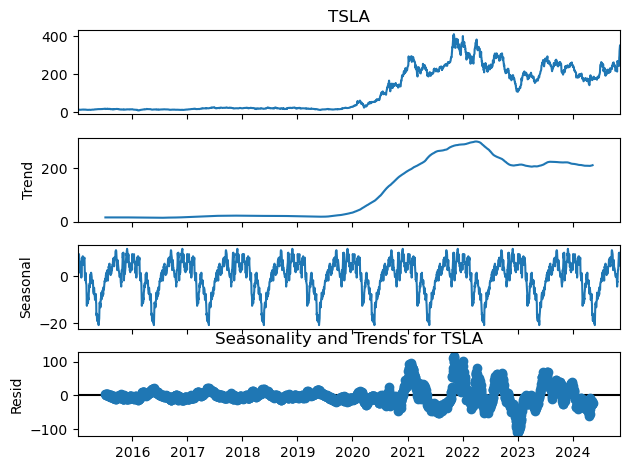

In [14]:
decomposition = seasonal_decompose(combined_data['TSLA'], model='additive', period=252)  # Approx. trading days in a year
decomposition.plot()
plt.title('Seasonality and Trends for TSLA')
plt.show()

## Analyze Volatility

### Calculate rolling means and standard deviations for TSLA


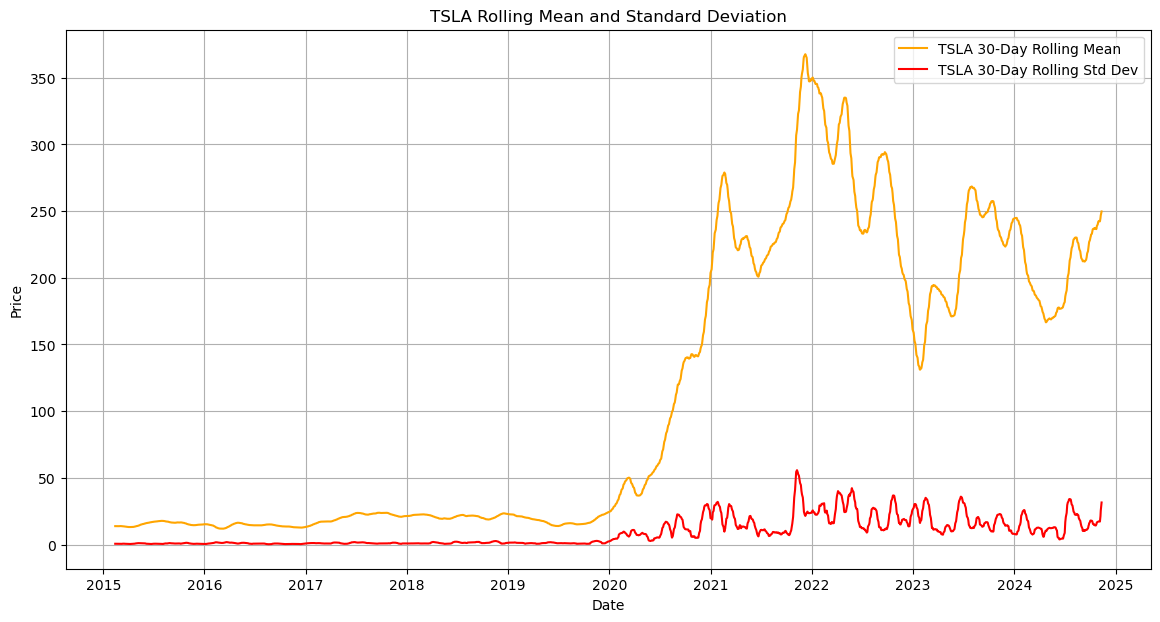

In [15]:
tsla_rolling_mean = combined_data['TSLA'].rolling(window=30).mean()
tsla_rolling_std = combined_data['TSLA'].rolling(window=30).std()

plt.figure(figsize=(14, 7))
plt.plot(tsla_rolling_mean, label='TSLA 30-Day Rolling Mean', color='orange')
plt.plot(tsla_rolling_std, label='TSLA 30-Day Rolling Std Dev', color='red')
plt.title('TSLA Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

##  Document Key Insights

### Calculate Sharpe Ratio and Value at Risk (VaR) for TSLA

In [16]:
sharpe_ratio = daily_returns['TSLA'].mean() / daily_returns['TSLA'].std() * np.sqrt(252)
VaR_95 = daily_returns['TSLA'].quantile(0.05)

print("\nKey Insights:")
print(f"Sharpe Ratio for TSLA: {sharpe_ratio:.2f}")
print(f"95% VaR for TSLA: {VaR_95:.2f}%")

# Sharpe Ratio and VaR calculations for BND and SPY
for ticker in ['BND', 'SPY']:
    sharpe_ratio = daily_returns[ticker].mean() / daily_returns[ticker].std() * np.sqrt(252)
    VaR_95 = daily_returns[ticker].quantile(0.05)
    print(f"Sharpe Ratio for {ticker}: {sharpe_ratio:.2f}")
    print(f"95% VaR for {ticker}: {VaR_95:.2f}%")


Key Insights:
Sharpe Ratio for TSLA: 0.85
95% VaR for TSLA: -5.12%
Sharpe Ratio for BND: 0.29
95% VaR for BND: -0.48%
Sharpe Ratio for SPY: 0.80
95% VaR for SPY: -1.68%


### Function to analyze seasonality, trends, and volatility


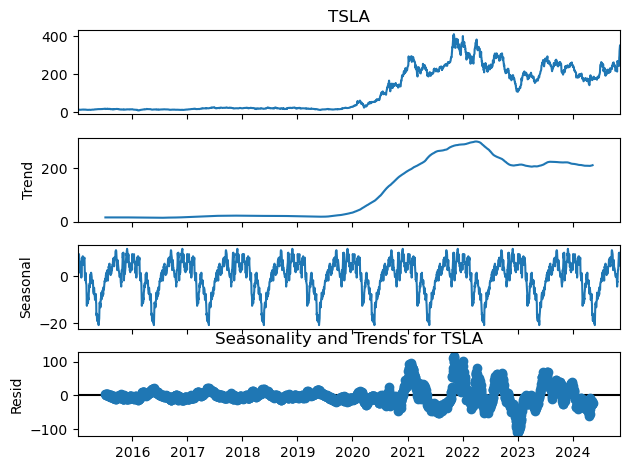

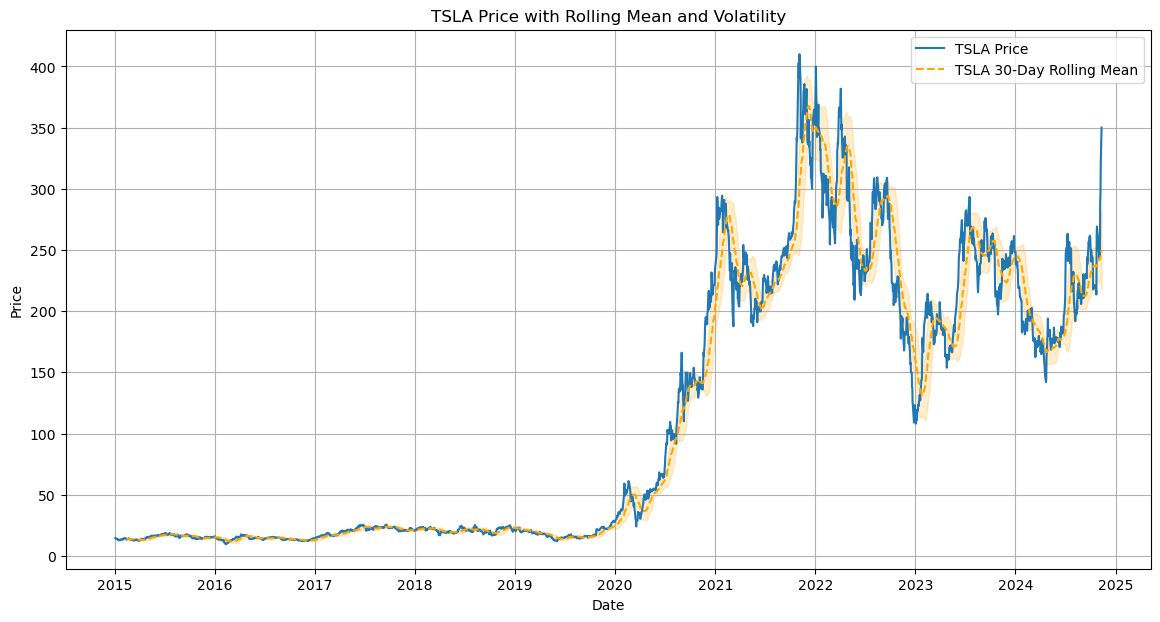


Sharpe Ratio for TSLA: 0.849450686623182
95% VaR for TSLA: -5.12345859010529


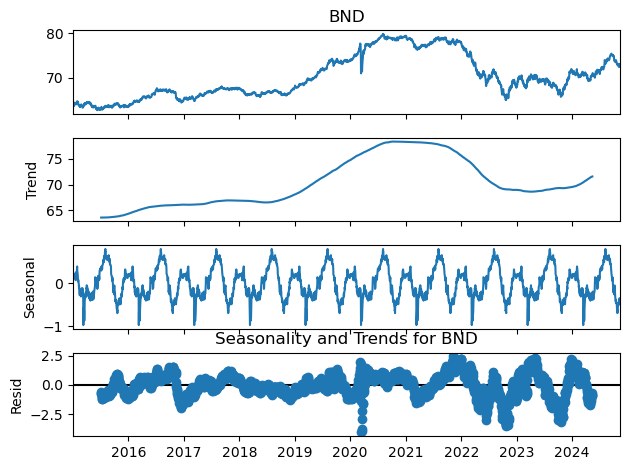

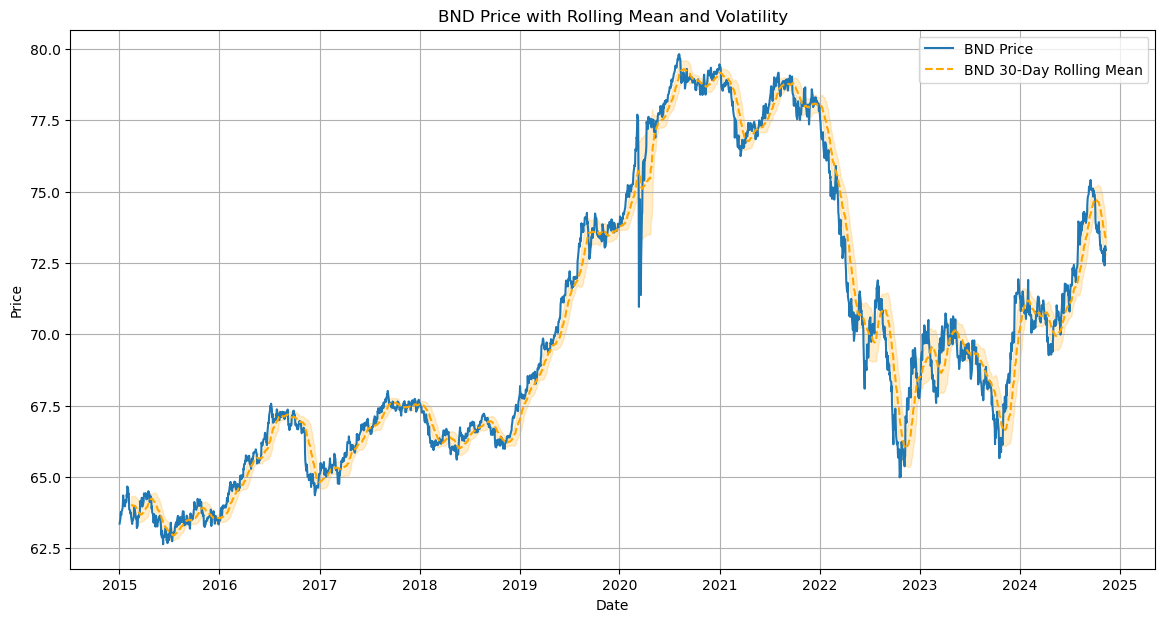


Sharpe Ratio for BND: 0.2899918680500218
95% VaR for BND: -0.4797924828494171


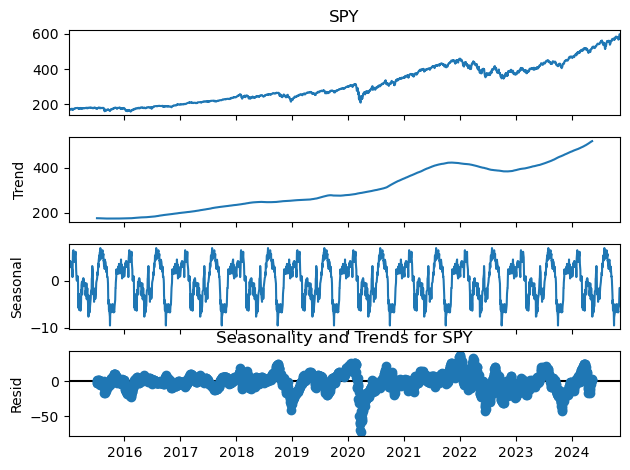

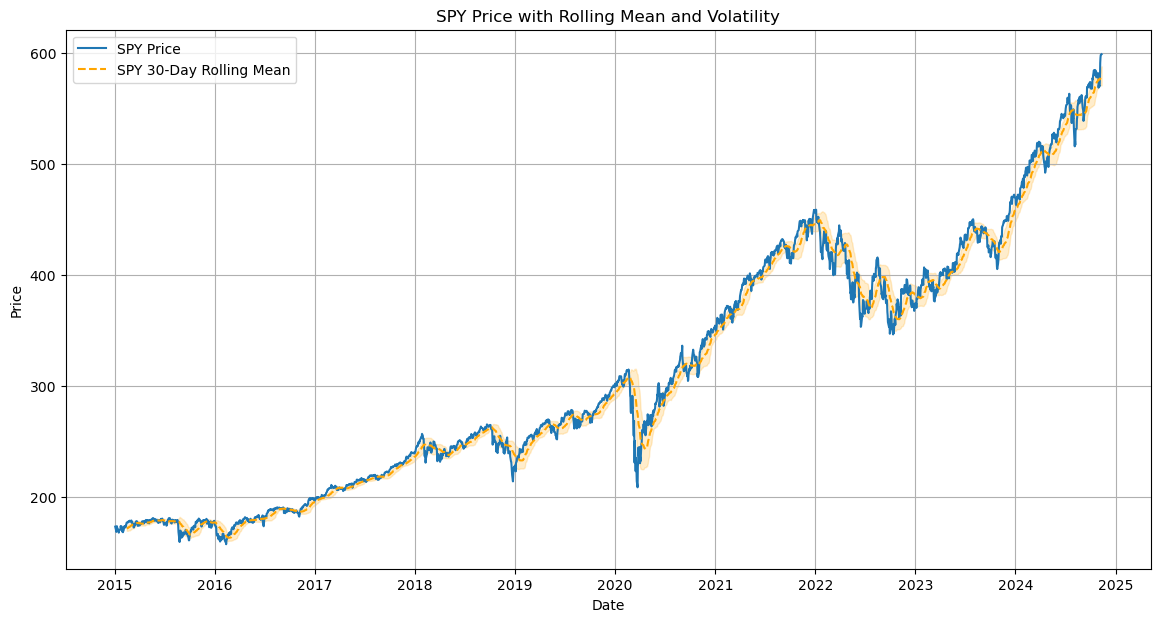


Sharpe Ratio for SPY: 0.8016224070594552
95% VaR for SPY: -1.6777309325147982


In [17]:
def analyze_asset(asset):
    # Decompose Time Series
    decomposition = seasonal_decompose(combined_data[asset], model='additive', period=252)
    decomposition.plot()
    plt.title(f'Seasonality and Trends for {asset}')
    plt.show()

    # Analyze Volatility
    rolling_mean = combined_data[asset].rolling(window=30).mean()
    rolling_std = combined_data[asset].rolling(window=30).std()

    plt.figure(figsize=(14, 7))
    plt.plot(combined_data[asset], label=f'{asset} Price')
    plt.plot(rolling_mean, label=f'{asset} 30-Day Rolling Mean', linestyle='--', color='orange')
    plt.fill_between(rolling_std.index, 
                     rolling_mean - rolling_std, 
                     rolling_mean + rolling_std, 
                     alpha=0.2, color='orange')
    plt.title(f'{asset} Price with Rolling Mean and Volatility')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate Sharpe Ratio and Value at Risk (VaR)
    sharpe_ratio = daily_returns[asset].mean() / daily_returns[asset].std() * (252 ** 0.5)
    VaR_95 = daily_returns[asset].quantile(0.05)

    print(f"\nSharpe Ratio for {asset}:", sharpe_ratio)
    print(f"95% VaR for {asset}:", VaR_95)

# Analyze each asset
for ticker in tickers:
    analyze_asset(ticker)

In [95]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout



###  Load the combined data


In [109]:
combined_data = combined_data.reset_index()
combined_data['Date'] = pd.to_datetime(combined_data['Date'])
combined_data.set_index('Date', inplace=True)

### Normalize the data


In [110]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data)  # Use this for model training

### Create sequences


In [131]:
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)
# 'TSLA' data is in the first column of the scaled data (index 0)
tsla_data = scaled_data[:, 0] 
time_step = 30  # Set your time step

# Split the dataset into train and test
train_size = int(len(tsla_data) * 0.8)
train_data = tsla_data[:train_size]
test_data = tsla_data[train_size:]

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)




### Reshape

In [132]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Build the LSTM Model

In [133]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer

C:\Users\King Betse\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 ### Compile the Model

In [134]:
model.compile(optimizer='adam', loss='mean_squared_error')


 ### Fit the Model

In [135]:
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0293
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0014
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013
Epoch 13/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018
Epoch 14/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013
Epoch 15/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011
Epoc

###  Make Predictions

In [157]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reshape predictions for inverse transformation
train_predict = train_predict.reshape(-1, 1)
test_predict = test_predict.reshape(-1, 1)

# Padding train and test predictions with zeros to match the original data shape
train_predict_padded = np.concatenate([train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))], axis=1)
test_predict_padded = np.concatenate([test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))], axis=1)

# Inverse transform
train_predict = scaler.inverse_transform(train_predict_padded)[:, 0]  # Only keep the first column (target variable)
test_predict = scaler.inverse_transform(test_predict_padded)[:, 0]

# Inverse transform for y_test as well if needed
y_test_padded = np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))], axis=1)
y_test = scaler.inverse_transform(y_test_padded)[:, 0]


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


### Evaluate the Model

In [158]:
mae = mean_absolute_error(y_test, test_predict)
rmse = mean_squared_error(y_test, test_predict, squared=False)
mape = mean_absolute_percentage_error(y_test, test_predict)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2%}')


MAE: 84802.91
RMSE: 86138.20
MAPE: 99.76%


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Plot the results

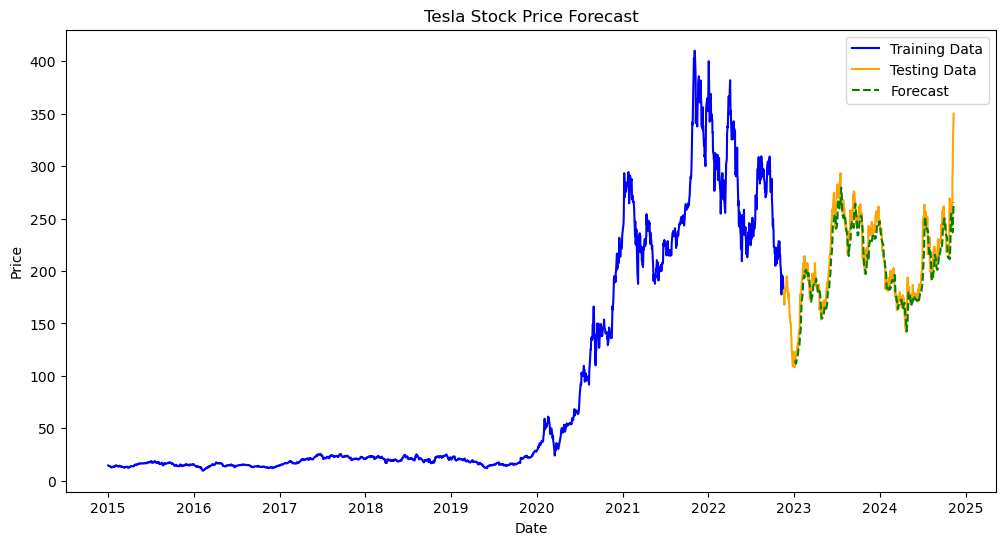

In [159]:
plt.figure(figsize=(12, 6))

# Plot original training and test data (non-scaled)
plt.plot(combined_data.index[:train_size], combined_data['TSLA'][:train_size], label='Training Data', color='blue')
plt.plot(combined_data.index[train_size:], combined_data['TSLA'][train_size:], label='Testing Data', color='orange')

# Plot forecast (predictions)
plt.plot(combined_data.index[train_size + time_step + 1:], test_predict, label='Forecast', color='green', linestyle='--')

plt.title('Tesla Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Generate forecasts


### Plotting the results


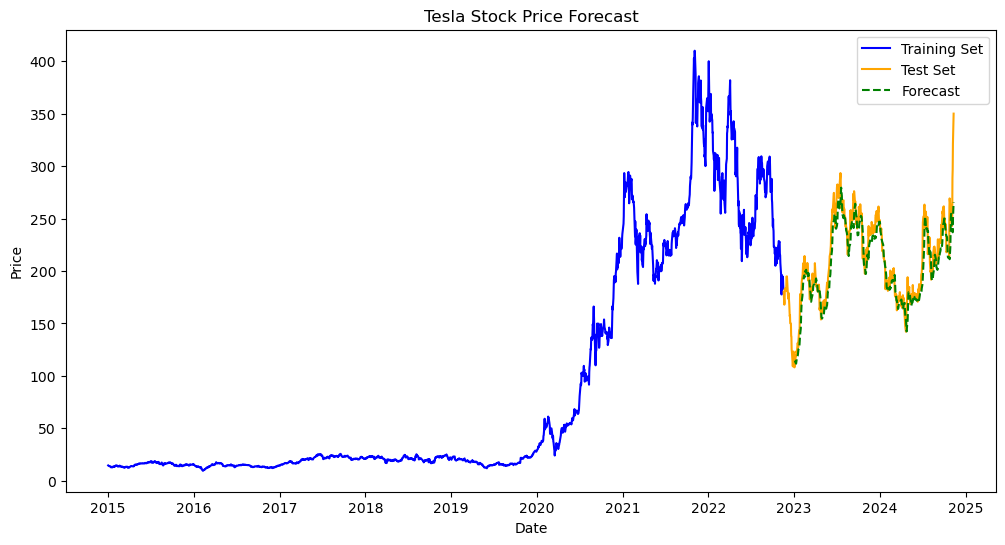

In [160]:
plt.figure(figsize=(12, 6))

# Plot original training and test data (non-scaled)
plt.plot(combined_data.index[:train_size], combined_data['TSLA'][:train_size], label='Training Set', color='blue')
plt.plot(combined_data.index[train_size:], combined_data['TSLA'][train_size:], label='Test Set', color='orange')

# Plot forecast (predictions)
plt.plot(combined_data.index[train_size + time_step + 1:], test_predict, label='Forecast', color='green', linestyle='--')

plt.title('Tesla Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



### Generate Future Predictions

In [175]:
# Forecast generation function with correct reshaping and confidence intervals
def generate_forecast_with_confidence(model, data, forecast_steps, time_step, scaler):
    forecast = []
    confidence_intervals = []

    # Start with the last 'time_step' values from the data
    last_data = data[-time_step:].reshape(1, time_step, 1)  # Shape should be (1, time_step, 1)

    for _ in range(forecast_steps):
        # Predict the next value
        next_prediction = model.predict(last_data)
        forecast.append(next_prediction[0, 0])  # Append the predicted value to the forecast

        # Generate confidence intervals (using standard deviation, this is a simple approximation)
        lower_bound = next_prediction[0, 0] - 0.05  # Assuming 5% margin for lower bound
        upper_bound = next_prediction[0, 0] + 0.05  # Assuming 5% margin for upper bound
        confidence_intervals.append([lower_bound, upper_bound])

        # Update the input data by adding the new prediction and removing the oldest data point
        last_data = np.append(last_data[:, 1:, :], next_prediction.reshape(1, 1, 1), axis=1)

    # Rescale forecast and confidence intervals
    forecast_rescaled = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    confidence_intervals_rescaled = scaler.inverse_transform(np.array(confidence_intervals))

    return forecast_rescaled, confidence_intervals_rescaled

# Generate forecast for future steps
forecast_steps = 252  # For 12 months of trading days
if isinstance(historical_data, dict):
    # Assuming the dictionary has dates as keys and prices as values
    historical_data = pd.DataFrame.from_dict(historical_data, orient='index', columns=['TSLA'])
    historical_data.index = pd.to_datetime(historical_data.index)  # Set the index to be a DateTime index

# If you are extracting from combined_data, ensure this line is correct:
historical_data = combined_data[['TSLA']].copy()  # Ensure it's a Da
# Ensure you pass the scaler to the function
forecast, confidence_intervals = generate_forecast_with_confidence(model, scaled_data, forecast_steps, time_step, scaler)

# Step 5: Create a date range for the forecast
last_date = combined_data.index[-1]  # Get the last date in the dataset
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='B')[1:]

# Step 6: Create DataFrames for the forecast
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])
confidence_intervals_df = pd.DataFrame(confidence_intervals, index=forecast_index, columns=['Lower Bound', 'Upper Bound'])

# Inverse transform the forecast to the original scale
forecast_rescaled = scaler.inverse_transform(forecast.reshape(-1, 1))


# Check types to ensure they are DataFrames
print("Type of historical_data:", type(historical_data))
print("Type of forecast_df:", type(forecast_df))
print("Type of confidence_intervals_df:", type(confidence_intervals_df))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

## Forecast Analysis

### Visualize the Forecast

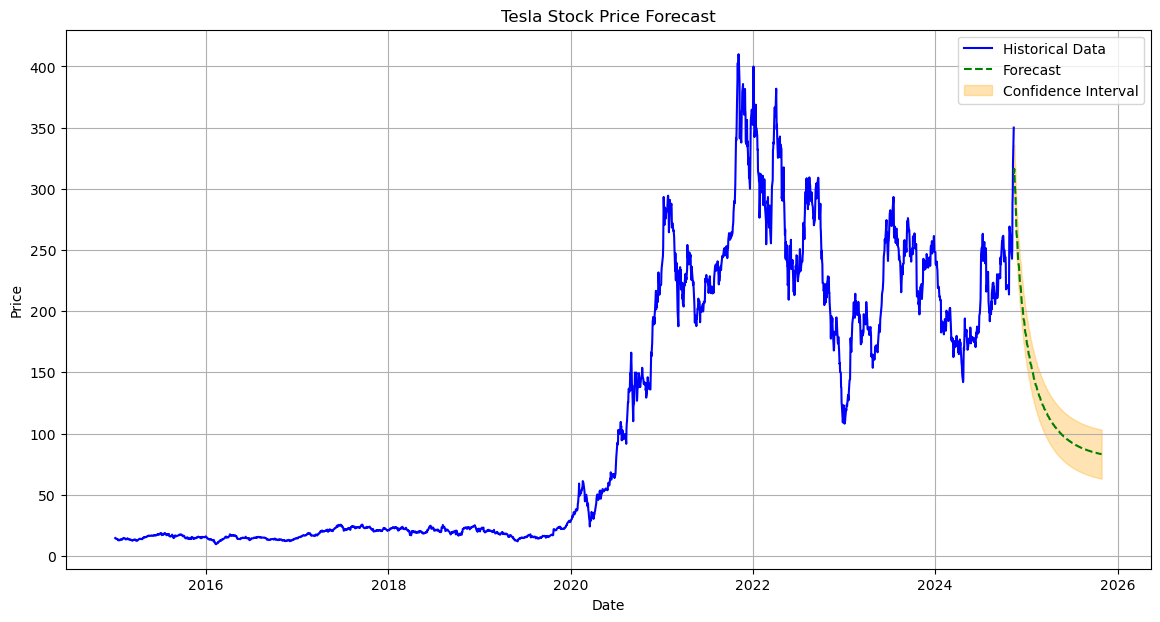

In [176]:
# Plotting
plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(historical_data.index, historical_data['TSLA'], label='Historical Data', color='blue')

# Plot forecasted data
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='green', linestyle='--')

# Plot confidence intervals
plt.fill_between(confidence_intervals_df.index, 
                 confidence_intervals_df['Lower Bound'], 
                 confidence_intervals_df['Upper Bound'], 
                 color='orange', alpha=0.3, label='Confidence Interval')

plt.title('Tesla Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Investment Portfolio

### Daily Returns


In [178]:
returns = combined_data.pct_change().dropna()

### Annualized Returns

In [179]:
annualized_returns = returns.mean() * 252  # Assuming 252 trading days
print("Annualized Returns:\n", annualized_returns)

Annualized Returns:
 TSLA    0.484951
BND     0.015807
SPY     0.141732
dtype: float64


### Covariance Matrix

In [180]:
cov_matrix = returns.cov() * 252  # Annualize the covariance matrix
annualized_returns = returns.mean() * 252  # Annualized returns

### Portfolio Weights and Returns

In [181]:
weights = np.array([0.33, 0.33, 0.34])  # Initial weights

# Calculate portfolio return and volatility
portfolio_return = np.sum(annualized_returns * weights)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

print(f'Initial Portfolio Return: {portfolio_return:.2f}')
print(f'Initial Portfolio Volatility: {portfolio_volatility:.2f}')

Initial Portfolio Return: 0.21
Initial Portfolio Volatility: 0.22


### Optimize the Portfolio

In [182]:
from scipy.optimize import minimize

# Define a function to calculate the negative Sharpe Ratio
def negative_sharpe_ratio(weights):
    portfolio_return = np.sum(annualized_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio  # Minimize the negative Sharpe Ratio

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((0, 1) for _ in range(len(weights)))

# Initial guess
initial_weights = weights

# Optimize
optimal_weights = minimize(negative_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

print(f'Optimal Weights: {optimal_weights.x}')

Optimal Weights: [0.13900519 0.49296675 0.36802806]


### Analyze Portfolio Risk and Return

### Calculate VaR

In [183]:
# Calculate daily portfolio returns based on optimal weights
portfolio_daily_returns = returns.dot(optimal_weights.x)

# Calculate VaR at the specified confidence level
confidence_level = 0.95
VaR = -np.percentile(portfolio_daily_returns, (1 - confidence_level) * 100)

print(f'Value at Risk (VaR) at {confidence_level * 100}% confidence level: {VaR:.2f}')

Value at Risk (VaR) at 95.0% confidence level: 0.01


###  Sharpe Ratio Calculation

In [184]:
portfolio_return_optimal = np.sum(annualized_returns * optimal_weights.x)
portfolio_volatility_optimal = np.sqrt(np.dot(optimal_weights.x.T, np.dot(cov_matrix, optimal_weights.x)))
sharpe_ratio_optimal = portfolio_return_optimal / portfolio_volatility_optimal

print(f'Optimized Portfolio Return: {portfolio_return_optimal:.2f}')
print(f'Optimized Portfolio Volatility: {portfolio_volatility_optimal:.2f}')
print(f'Optimized Portfolio Sharpe Ratio: {sharpe_ratio_optimal:.2f}')

Optimized Portfolio Return: 0.13
Optimized Portfolio Volatility: 0.13
Optimized Portfolio Sharpe Ratio: 0.99


### Visualizations and Summaries

### Cumulative Return Chart

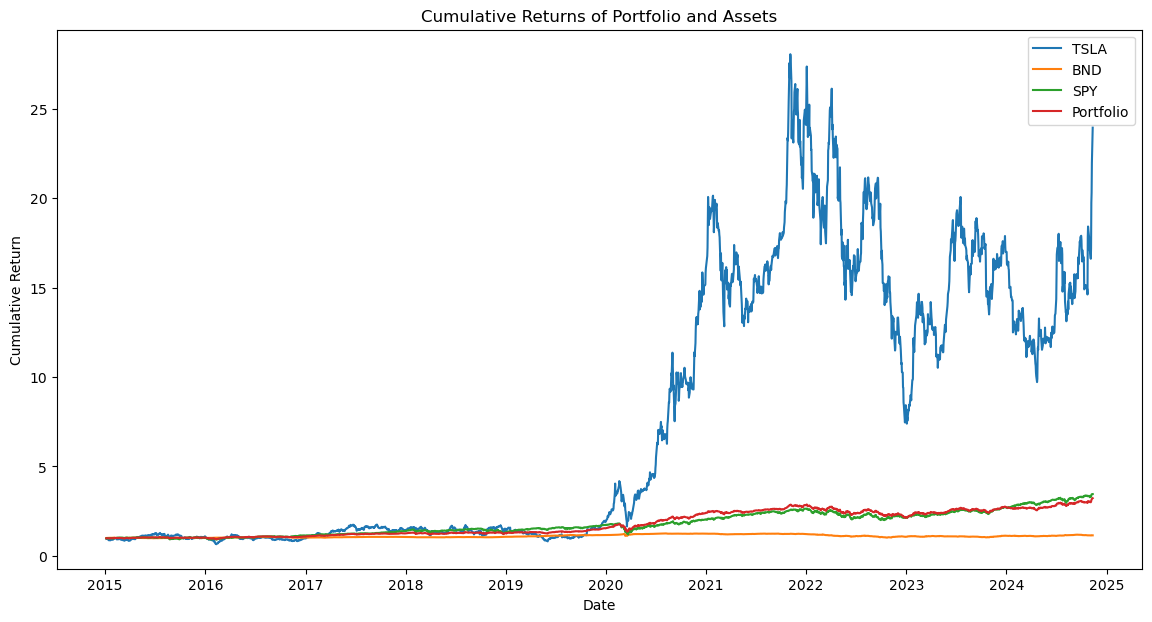

In [185]:
# Calculate cumulative returns
cumulative_returns = (returns + 1).cumprod()
cumulative_returns['Portfolio'] = (returns.dot(optimal_weights.x) + 1).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns)
plt.title('Cumulative Returns of Portfolio and Assets')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(cumulative_returns.columns)
plt.show()